In [1]:
import psycopg2, multiprocessing, psycopg2.extras, os, json, sys, time, scipy, datetime
from multiprocessing import Pool, Manager 
from collections import Counter
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Temporal Clustering

In [2]:
input_directory  = "/data/chime/geo/sandy_new_jersey_geovulnerable_contextual_stage1/"
output_directory = "/data/chime/geo/sandy_new_jersey_geovulnerable_contextual_stage2"

#SANDY
_landfall_str = '201210300000' #Need to define the new dates for Hurricane Matthew in these zones?
_start_str    = '201210290000' # (ie when was the evacuation?)
_end_str      = '201210310000'
_landfall = pd.Timestamp(_landfall_str)
_start    = pd.Timestamp(_start_str)
_end      = pd.Timestamp(_end_str)

#MATTHEW
# _landfall_str = '201610060000' #Using these dates for Matthew...
# _start_str    = '201610040000' # (ie when was the evacuation?)
# _end_str      = '201610080000'
# _landfall = pd.Timestamp(_landfall_str)
# _start    = pd.Timestamp(_start_str)
# _end      = pd.Timestamp(_end_str)

## 0. Load all the geo-clustered tweets

In [3]:
users_in = sorted(os.listdir(input_directory))
print("Found {0} users in {1}".format(len(users_in), input_directory))

Found 330 users in /data/chime/geo/sandy_new_jersey_geovulnerable_contextual_stage1/


In [4]:
def loader_function(args):
    uFile, path, q = args
    u = json.load(open(path+"/"+uFile,'r'))
    tweets = []
    for t in u['features']:
        if t['geometry']:
            t['properties']['geometry'] = shape(t['geometry'])
        t['properties']['date'] = pd.Timestamp(t['properties']['date'])
        tweets.append(t['properties'])
    q.put(1)
    return gpd.GeoDataFrame(tweets)

In [5]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, input_directory, q) for i in users_in]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))
users = result.get()
p.close()

Processed: 330, 100%

In [6]:
print("{0} total tweets for all users".format(sum([len(x) for x in users])))

280772 total tweets for all users


In [7]:
user_names_in = [x[:-8] for x in users_in]
user_names_in[:10]

['08243',
 '1stfitnessmc',
 '_daniellevaldez',
 'aclive35',
 'adtwenty7',
 'aimee_sh',
 'alanjonesbeats',
 'alex_florke',
 'alexrosenkranz',
 'alreadywifedup1']

# Identifying Temporal Clusters
Use a custom _worker_ function to find specific time clusters

## 1. Enough Tweets?

Ensure that we have the following for each user:
1. Geo-Cluter Information (If no geo-clusters are available, remove)
2. Enough Tweets (At least *A* Tweet during the storm)

In [8]:
def time_cluster(t):
    t = t.tz_convert("EST")
    '''Get the timecluster'''
    hour = t.hour//4 + 1
    if t.weekday()>4:
        return 6+hour
    else:
        return hour
    
def worker_function(args):
    userDF, q = args
    
    #If no tweets around the time of the storm, then fail.
    if len(userDF.query("date > %s & date < %s"%(_start_str, _end_str))) < 1:
        q.put(1)
        return None
    
    userDF['day_cluster'] = userDF.date.apply(lambda t: time_cluster(t))
    q.put(0)
    return userDF

In [9]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in users]
result = p.map_async(worker_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))

values = result.get()
x = [i for i in values  if i is not None]
nones = [i for i in values  if i is None]
p.close()

Processed: 330, 100%

In [10]:
print("Successfully processed {0} users\n{1} Users failed".format(len(x),len(nones)))

Successfully processed 330 users
0 Users failed


In [11]:
users_past_first_step = [x.user[0].lower() for x in values if x is not None]

In [12]:
users_past_first_step[:10]

['08243',
 '1stfitnessmc',
 '_daniellevaldez',
 'aclive35',
 'adtwenty7',
 'aimee_sh',
 'alanjonesbeats',
 'alex_florke',
 'alexrosenkranz',
 'alreadywifedup1']

In [13]:
#Failed:
set(user_names_in) - set(users_past_first_step)

set()

In [14]:
_users = sorted(x, key=lambda y: len(y), reverse=True)

## 2. Group the clusters and find which geo-clusters correspond with home hours

In [15]:
def rank_clusters(df):
    """
    There is definitely room for the logic in _this_ function to improve, but for now it looks good :) 
    """
    gb_geo = df.query('date < '+_start_str).groupby('cluster')
    if len(gb_geo) < 1:
        return (None,None)
    _agged = gb_geo['day_cluster'].agg({"tweets":pd.Series.count,
                                        "Number Unique Times":pd.Series.nunique,
                                        "day_cluster_counts": lambda t: Counter(t),
                                        "HomeTimes": lambda t: any(t==1) or any(t==2) or any(t==6),
                                      }).sort_values('Number Unique Times', ascending=False).query('cluster>0')
    hc = None
    
    #If there is a cluster with hometimes, then return that (highest rated based on unique times)
    if len(_agged.query('HomeTimes'))>0:
        hc = _agged.query('HomeTimes').iloc[0].name
        
    return hc, _agged

In [16]:
vals= []
len_users = len(_users)
user_collection = []

user_meta_collection = []
for idx, U in enumerate(_users):
    
    hc = rank_clusters(U)[0]
    if hc is None:
        hc_coords = None
    else:
        hc_coords = U.query("cluster=={0}".format(hc))['cluster_center'].values[0]
        
    user_meta_collection.append({
            'user':U['user'].values[0],
            'uid' :U['uid'].values[0],
            'tweets':len(U),
            'home_cluster': hc,
            'home_cluster_coords':hc_coords
        })

    U['home_cluster_id'] = pd.Series(hc)
    
    sys.stderr.write("\r{0} of {1}".format(idx+1, len_users))
_user_meta = pd.DataFrame(user_meta_collection)
sys.stderr.write("\n\nClustered: {0}, Failed: {1}".format( len(_user_meta[~np.isnan(_user_meta.home_cluster)]),
                                                           len(_user_meta[ np.isnan(_user_meta.home_cluster)])))

330 of 330

Clustered: 329, Failed: 1

In [17]:
users_with_homes = [u for u in _users if u.home_cluster_id.count()>0]

Identify which users do not make it past?

In [18]:
users_past_second_step = [x.user[0].lower() for x in users_with_homes]

In [19]:
pitched_users = set(user_names_in) - set(users_past_second_step)
len(pitched_users)

1

### Export these results

In [21]:
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [22]:
#Export the User Meta Dataframe first
with open(output_directory+'/'+'temporal_clustered_user_meta.json','w') as metaOut:
    metaOut.write(_user_meta.to_json())

In [23]:
_user_meta.head()

,home_cluster,home_cluster_coords,tweets,uid,user
0,1.0,"{""type"": ""Point"", ""coordinates"": [-74.10081558...",14298,139283160,kr3at
1,3.0,"{""type"": ""Point"", ""coordinates"": [-74.02165222...",7916,243393072,MsRockHerHips
2,1.0,"{""type"": ""Point"", ""coordinates"": [-74.90685881...",5121,627593291,Cwalks3
3,1.0,"{""type"": ""Point"", ""coordinates"": [-74.72309297...",4988,339306571,Shell_Babii
4,1.0,"{""type"": ""Point"", ""coordinates"": [-74.40502972...",4396,318103926,lanceeryann


## 3.  Write these users to disk

In [24]:
def safe_mapping(p):
    if p==None or np.isnan(p).any():
        return None
    else:
        return mapping(p)

In [25]:
def safe_json_export(args):
    df, path, q = args
    df = df.copy()
    uName = df.head(1).user.values[0].lower()
    df['date'] = df['date'].apply(lambda t: datetime.datetime.strftime(t,'%Y-%m-%dT%H:%M:%SZ'))

    #Write the metadata:
    with open('/data/www/chime/movement-derivation/user-metadata/'+uName+".geojson",'w') as userMeta:
        userMeta.write(df.query("cluster=={0}".format(df.iloc[0].home_cluster_id)).cluster_center.values[0])

    clean = df.where((pd.notnull(df)), None)
    geojson = {"type":"FeatureCollection","features":[]}
    for _, row in clean.iterrows():
        geom = safe_mapping(row.geometry)
        feature = {'type':'Feature',
                   'geometry':geom,
                   'properties':row.to_dict()
                    }
        del feature['properties']['geometry']
        geojson['features'].append(feature)
    
    with open(path+"/"+uName+'.geojson','w') as oFile:
        json.dump(geojson, oFile) 

    if q is not None:
        q.put(1)

In [26]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, output_directory, q) for i in users_with_homes]
result = p.map_async(safe_json_export, args)

sys.stderr.write("Exporting {0} users to {1}\n".format(len(args),output_directory))

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
p.close()
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))

Exporting 329 users to /data/chime/geo/sandy_new_jersey_geovulnerable_contextual_stage2
Processed: 329, 100%

<hr>
<hr>
# End of Processing 

<hr><hr>
# Beginning of Visual Inspection

In [45]:
x = users_with_homes[0]

In [46]:
x.cluster.count()

287

In [47]:
cluster_dist = pd.Series(sorted([u.cluster.nunique() for u in _users]))

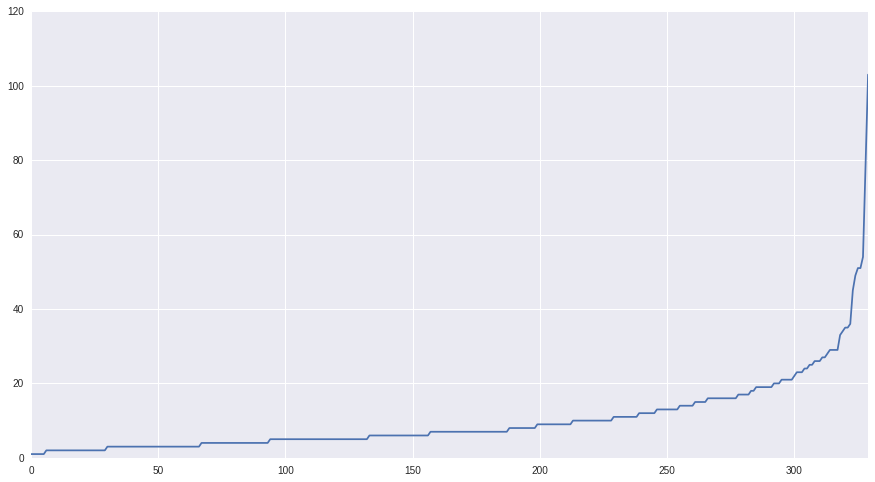

In [48]:
cluster_dist.plot(figsize=(15,8))

In [54]:
x.head(15)

,cluster,cluster_center,coords,date,geo_delta,geometry,speed,text,time_delta,tweet_id,uid,user,day_cluster,home_cluster_id
0,NaN,null,None,2012-09-01 04:06:22+00:00,NaN,NaN,NaN,A New Hot War Against Liberty http://t.co/Omjn...,-6560813.0,241748810706063360,139283160,kr3at,6,1.0
1,NaN,null,None,2012-09-01 04:11:35+00:00,NaN,NaN,NaN,Does This Recruiting Video Reveal The Creators...,313.0,241750122059399168,139283160,kr3at,6,NaN
2,NaN,null,None,2012-09-01 04:16:19+00:00,NaN,NaN,NaN,Evacuee: 'The water kept coming' http://t.co/k...,284.0,241751313988337664,139283160,kr3at,6,NaN
3,NaN,null,None,2012-09-01 04:17:53+00:00,NaN,NaN,NaN,RNC pays tribute to the Bushes http://t.co/oXc...,94.0,241751708282281984,139283160,kr3at,6,NaN
4,NaN,null,None,2012-09-01 04:19:28+00:00,NaN,NaN,NaN,GOP convention targets Obama http://t.co/FvEkl...,95.0,241752107185754112,139283160,kr3at,6,NaN
5,NaN,null,None,2012-09-01 04:21:02+00:00,NaN,NaN,NaN,Death toll rises in China coal mine blast http...,94.0,241752502989635584,139283160,kr3at,6,NaN
6,NaN,null,None,2012-09-01 04:36:42+00:00,NaN,NaN,NaN,NATO troops killed in Afghan insider attack ht...,940.0,241756445220151296,139283160,kr3at,6,NaN
7,NaN,null,None,2012-09-01 04:48:34+00:00,NaN,NaN,NaN,The Conspiracy of an Empire: A Letter to Those...,712.0,241759431497510912,139283160,kr3at,6,NaN
8,NaN,null,None,2012-09-01 04:56:50+00:00,NaN,NaN,NaN,The Conspiracy of an Empire: A Letter to Those...,496.0,241761510848880640,139283160,kr3at,6,NaN
9,NaN,null,None,2012-09-01 05:06:50+00:00,NaN,NaN,NaN,The Deliberate Assault on American Liberties w...,600.0,241764026697256960,139283160,kr3at,7,NaN
